# Cell detection and segmentation in two-photon stacks
Network based on the Mask-RCNN architecture to detect and segment all cells in a 3-d stack; it requires isotropic inputs at 1 um^3 resolution. We tested it in stacks recorded from four diff microscopes: 2 two-photon, one three-photon and one mesoscope.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Load network
from bl3d import models

net = models.MaskRCNN()
net.load_state_dict(torch.load('data/model_18-1-17026.pth'))
net.to(device)
net.eval()
print(net)

MaskRCNN(
  (core): DenseNet(
    (conv1): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), bias=False)
    (bn1): BatchNorm3d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv3d(9, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), bias=False)
    (bn2): BatchNorm3d(17, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv3d(17, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), dilation=(2, 2, 2), bias=False)
    (bn3): BatchNorm3d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv3d(25, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), dilation=(2, 2, 2), bias=False)
    (bn4): BatchNorm3d(33, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv5): Conv3d(33, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), dilation=(3, 3, 3))
  )
  (rpn): RPN(
    (conv1): Conv3d(41, 48, kernel_size=(3, 3, 3), stride=(1, 1, 1), dilation=(3, 3, 3), bias=False)
    (bn1): BatchNorm3d(48, eps=1e-05, mome

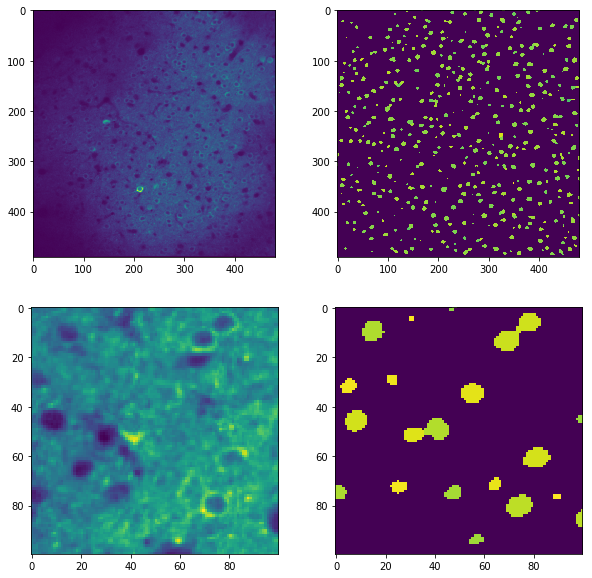

In [3]:
# Load stack (199 x 491 x 481 mm^3); this is corrected and rescaled to 1 um^3 per voxel
stack = np.load('data/example1_17026-20-1.npy') # this example was used for validation during training
label = np.load('data/label1_17026-20-1.npy')

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes[0, 0].imshow(stack[100])
axes[0, 1].imshow(label[100])
axes[1, 0].imshow(stack[100, 200:300, 200:300])
axes[1, 1].imshow(label[100, 200:300, 200:300])

Getting proposals
Applying non maximum suppresion on proposals (CPU)
Getting proposal's ROIS (CPU)
Refining bboxes
Applying non maximum suppression on bboxes (CPU)
Getting final masks' ROIS (CPU)
Segmenting final bboxes


/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0., 7050.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.]),
 array([-0.33098537, -0.31098537, -0.29098537, -0.27098537, -0.25098537,
        -0.23098537, -0.21098537, -0.19098537, -0.17098537, -0.15098537,
        -0.13098537, -0.11098537, -0.09098537, -0.07098537, -0.05098537,
        -0.03098537, -0.01098537,  0.00901463,  0.02901463,  0.04901463,
         0.06901463,  0.08901463,  0.10901463,  0.12901463,  0.14901463,
         0.16901463,  0.18901463,  0.20901463,  0.22901463,  0.24901463,
         0.26901463,  0.28901463,  0.30901463,  0.32901463,  0.34901463,
         0.36901463,  0.38901463,  0.40901463,  0.42901463,  0.44901463,
         0.46901

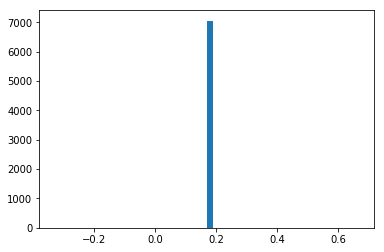

In [4]:
# Prepare input
norm = (stack - stack.mean()) / stack.std()
input_ = torch.as_tensor(norm[np.newaxis, np.newaxis, ...]).to(device) # 1 x 1 x D x H x W
num_cells = np.prod(stack.shape) * 0.0001 # estimate assuming 100 um ^3 = 100 cells, 1 mm^3 = 100K cells, 1 cm^3 = 100M cells, etc.
num_proposals = int(round(num_cells * 3))
num_final_masks = int(round(num_cells * 1.5))

# Segment
with torch.no_grad():
    probs, bboxes, masks = net.forward_eval(input_, num_proposals, num_final_masks) # this may take up to 30 minutes (CPU bound)

# Convert logits to valid probabilities
probs = 1 / (1 + np.exp(-probs)) # sigmoid
masks = [1 / (1 + np.exp(-m)) for m in masks]
binary_masks = [m > 0.5 for m in masks]
plt.hist(probs, bins=50)

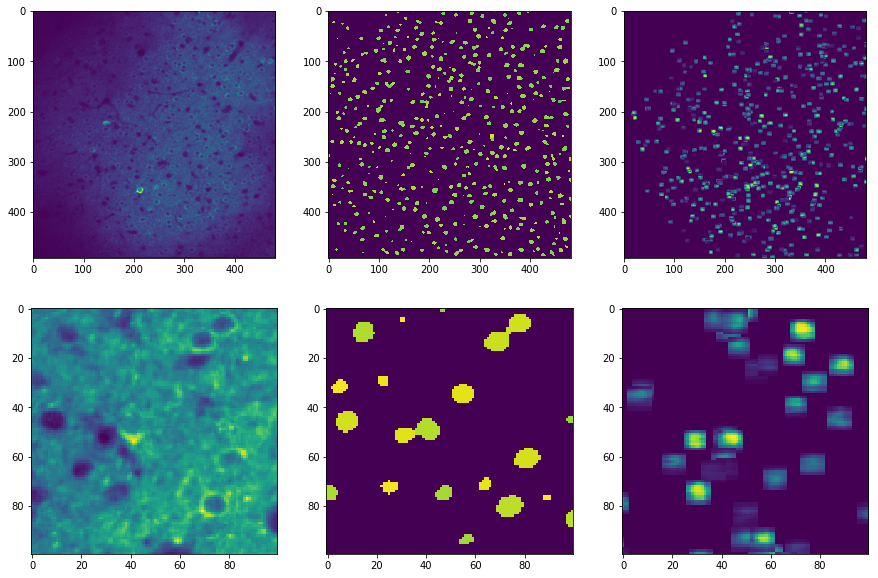

In [7]:
from bl3d import utils
#full_mask = utils.combine_masks(stack.shape, binary_masks, bboxes)
full_mask = utils.combine_masks(stack.shape, masks, bboxes, use_ids=False)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes[0, 0].imshow(stack[100])
axes[0, 1].imshow(label[100])
axes[0, 2].imshow(full_mask[100])
axes[1, 0].imshow(stack[100, 200:300, 200:300])
axes[1, 1].imshow(label[100, 200:300, 200:300])
axes[1, 2].imshow(full_mask[100, 200:300, 200:300])

In [6]:
probs

array([0.16901463, 0.16901463, 0.16901463, ..., 0.16901463, 0.16901463,
       0.16901463])

## Scripts (useful only with access to the original data)
### Training
We trained the networks with 128^3 crops from the original stack for 140 epochs in a couple of Tesla V100 GPUs (networks consume ~27 GB of memory during training).

In [ ]:
import torch
torch.cuda.set_device(0)
torch.backends.cudnn.benchmark=True 
from bl3d import train
train.TrainedModel().populate(reserve_jobs=True)

### Evaluation
We compute mAP and some other instance segmentation evaluation metrics. These can be run in ~8 GB of memory.

In [ ]:
import torch
torch.cuda.set_device(3)
torch.backends.cudnn.benchmark=True 
from bl3d import evaluate
evaluate.Metrics().populate(reserve_jobs=True)